[View in Colaboratory](https://colab.research.google.com/github/thochewa/SmallDatasetsManuscript/blob/master/SmallDatasetsMS_resnext50.ipynb)

#  Image classification for small datasets with CNNs

The script is intended to run on [Google Colab](https://colab.research.google.com). This requires installing pytorch and fast.ai packages always in the beginning.




## Debugging
* if you get **strange errors**, missing functions etc., run the pip install --upgrade functions below
* if you **still get strange errors**, restart your runtime
* if you run **out of GPU memory**, restart your runtime
* if you have worked on Colab the whole day, you find that **Colab hangs up**: run the 'kill' command
* If **you cannot download or upload files**, re-import 'files' from 'google.colab' again

In [0]:
## To start with clean environment // it resets docker and VE
## It helps to resolve wired and un-understandable errors
#!kill -9 -1

In [0]:
# For automatic inline plotting
%matplotlib inline

In [0]:
# Preparing environment for GoogleColab
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl && pip install torchvision 
!pip install fastai
!pip install pillow

# If later on, you get strange errors of missing functions, PIL, etc., unblock the below and update these libs
#!pip3 install torch --upgrade
#!pip install fastai --upgrade 
#!pip install pillow --upgrade

## Task: Build a model for datasets below 5000 images and more than 10 classes
* the model should be run on the resnet 34, resnet50 and resNext50 architecture
* for this, change the 'arch' function below


In [0]:
# Load libraries
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from google.colab import files
import os

## Change directory to import model weight files

In [42]:
# import os lib and change directory for model weight import
os.chdir('/usr/local/lib/python3.6/dist-packages/fastai/')
!ls -a

.		     fp16.py		  metrics.py	 swa.py
..		     imports.py		  model.py	 text.py
adaptive_softmax.py  initializers.py	  models	 torch_imports.py
column_data.py	     __init__.py	  nlp.py	 transforms_pil.py
conv_learner.py      io.py		  plots.py	 transforms.py
core.py		     layer_optimizer.py   __pycache__	 utils.py
dataloader.py	     layers.py		  rnn_reg.py	 weights
dataset.py	     learner.py		  rnn_train.py	 weights.tgz
datFolder	     lm_rnn.py		  set_spawn.py
datFolder.zip	     losses.py		  sgdr.py
executors.py	     lsuv_initializer.py  structured.py


In [0]:
# get and unpack model weights 
!wget http://files.fast.ai/models/weights.tgz
!tar -xvzf weights.tgz

The package CuDNN will improve training performance significantly. The following should return True.

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## Load in external data from local drive.


In [0]:
# Load external data from local disk
uploaded = files.upload()

In [0]:
# Unzip data file - in Colab, it should contain the right folder structure
!unzip datFolder.zip

## Inspect data

Data is organized in *train* and *valid* directories with species image files in each.
`PATH` sets the path to the data - since this is running in colab, we always have to re-create the directory as well; 

In [0]:
# the folder name should be the base directory of your imported dataset
PATH = "datFolder/"

In [12]:
!ls {PATH}

Readme_Bee Data.md  train  valid


In [13]:
# Check the files
filz = os.listdir(f'{PATH}/train')[:5]
filz

['OsmiaBicornis',
 'MelectaAlbifrons',
 'Group_NomadaSpp',
 'Group_Lasioglossum',
 'AndrenaFlavipes']

In [16]:
# Accessing the training data
fn = PATH+data.trn_ds.fnames[0]; fn


'datFolder/train/AndrenaBicolor/AndrenaBicolor043.jpg'

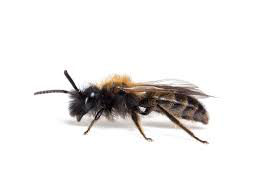

In [17]:
# Test image - is it centered?
img = PIL.Image.open(fn); img

### Checking size distribution of images in test dataset

(array([   2.,   38.,  166.,  566., 1094.,  952.,   27.,   10.,    3.,    3.]),
 array([ 89. , 124.9, 160.8, 196.7, 232.6, 268.5, 304.4, 340.3, 376.2, 412.1, 448. ]),
 <a list of 10 Patch objects>)

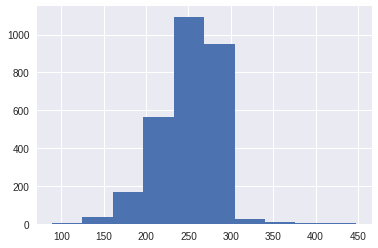

In [18]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)
row_sz[:5]

# Identify row sizes / if row size is >500px you may want to crop
plt.hist(row_sz)

## Data Preparation and Augmentation

In [0]:
## Set architecture, image 'sz' and batch 'bs' sizes 
# `sz` is the image sizing parameter
# `bs` sets batch size; 
# `arch` sets model architecture (use 'resnet34', resnet50, resnext50)
arch=resnext50
sz = 200
bs = 64

In [15]:
# Define data function and get data
def get_data(sz,bs):
  tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  data = ImageClassifierData.from_paths(PATH, num_workers=4, tfms=tfms, bs=bs)
  return data if sz>300 else data.resize(340, 'tmp')


data = get_data(sz,bs)

### Inspect augmented images

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, num_workers=4, tfms=tfms, bs=bs)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
ims = np.stack([get_augs() for i in range(6)])

In [0]:
plots(ims, rows=2)

## The SGDR Model Output to Report for the Paper
* report the model output Accuracy, Epochs, and Time
* report batchsize (bs) and the model architecture (arch)


The <b>pre-trained</b> CNN ImageNet (1.2 mio images in 1000 classes) model is a starting point. Here, we need to run the model with the <b>resnet34</b>, <b>resnet50</b>, and <b>resnext50</b> model.

In [0]:
# you may want to try different learning rates, drop out values - below config worked best for my dataset
learn = ConvLearner.pretrained(arch, data, ps=0.4, precompute=True)
%time learn.fit(1e-2, 3, cycle_len=2)      # the '%time' command gives you the timing of the model fit

###Load saved model layers
* only applicable after unfinished restart
* The following code creates the directory for saving the trained layer file, changes the WD and uploads the pretrained layers 

In [0]:
learn.save('SGDR_resnext50')
learn.load('SGDR_resnext50')

In [0]:
# Show location of stored file
os.listdir(f'{PATH}/tmp/340/models/')

In [0]:
# Download layer file // this may take a while
from google.colab import files 
downloaded = files.download(f'{PATH}/tmp/340/models/SGDR_resnext50.h5')

In [0]:
# Load external trained layer from local disk // unblock if you need to reload the layer
# from google.colab import files
# uploaded = files.upload()

### Find best learning rate

 96%|█████████▌| 43/45 [00:01<00:00, 40.60it/s, loss=18.6]


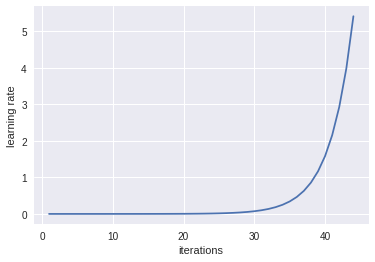

In [24]:
lrf=learn.lr_find()
learn.sched.plot_lr()

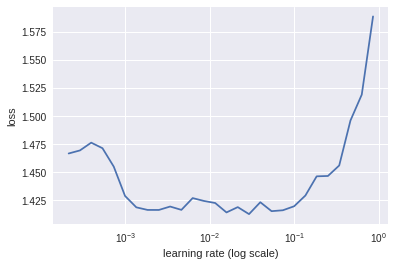

In [25]:
# identify ideal LR
learn.sched.plot()

## The CLRS Model Output to Report for the Paper
* report the model output Accuracy, Epochs, and Time
* report batchsize (bs) and the model architecture (arch)

In [0]:
# After testing varying learning rate, multiple epochs and different learning rates, this was the best one
# 5 epochs, 2 cycles (overfitting), 2 cycyle mults
# precompute off
learn.precompute=False
%time learn.fit(1e-2, 5, cycle_len=2, cycle_mult=2)

In [0]:
# plotting the loss function
learn.sched.plot_loss()

In [0]:
# Save last trained layer
learn.save('CLRS_ResNext50')
learn.load('CLRS_ResNext50')

In [0]:
# Somethimes, you need to re-import files from google.colab for this to work - for whatever reason..
from google.colab import files 
downloaded = files.download(f'{PATH}/tmp/340/models/CLRS_ResNext50.h5')

## The ISI Model Output to Report for the Paper
* report the model output Accuracy, Epochs, and Time
* report batchsize (bs) and the model architecture (arch)

According to Jeremy Howard, this increases accuracy - and it does indeed :D

In [0]:
# updating sizing and batch size
# for resnext50 I had to decrease bs, otherwise I am running into an 'Out of GPU memory error'
# for other arch, bs=64 was fine

sz_up = 250
bs = 25        

learn.set_data(get_data(sz_up, bs))
learn.freeze()

In [0]:
%time learn.fit(1e-2, 5, cycle_len=2)

In [0]:
# plotting the loss function
learn.sched.plot_loss()

In [0]:
# Checking the learning rate plotter again
learn.sched.plot_lr()

In [0]:
# Save last trained layer // ISI means 'Image Size Increase'
learn.save('ISI_resNext50')
learn.load('ISI_resNext50')
downloaded = files.download(f'{PATH}/tmp/340/models/ISI_resNext50.h5')

## The TTA Model Output to Report for the Paper
* report the model output Accuracy, Epochs, and Time
* report batchsize (bs) and the model architecture (arch)

In [0]:
# TTA improvement
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [0]:
# Save last trained layer // 'TTA' is 'Test Time Augmentation'
learn.save('TTA_resNext50')
learn.load('TTA_resNext50')
downloaded = files.download(f'{PATH}/tmp/340/models/TTA_resNext50.h5')

## The RPL Model Output to Report for the Paper
* report the model output Accuracy, Epochs, and Time
* report batchsize (bs) and the model architecture (arch)

In [0]:
#Unfreeze the lower layers for re-training
learn.unfreeze()

In [0]:
# Setting up differential learning rates
lr=np.array([1e-4,1e-3,1e-2])

In [0]:
# Fitting model with differential learning rates
%time learn.fit(lr, 25, cycle_len=2)

In [0]:
# Save trained model // 'RPL' means 'Re-training Pre-trained Layers'
learn.save('RPL_resNext50')
learn.load('RPL_resNext50')
downloaded = files.download(f'{PATH}/tmp/340/models/RPL.h5')

In [0]:
# Check learning rate plotter
learn.sched.plot_lr()

In [0]:
# Check loss function again
learn.sched.plot_loss()     # for better visualization, modify the (n_skip=40, n_skip_end=1) paras

##Confusion Matrix

In [0]:
# inspect results with confusion matrix
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)
y= data.val_y

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [0]:
plot_confusion_matrix(cm, data.classes)

## Predict from single image

In [0]:
# To predict out single images

def pred_img(file_nm):
    trn_tfms, val_tfms = tfms_from_model(downloaded,200) 
    test_img = val_tfms(open_image(file_nm)) # Load Image using fastai open_image in dataset.py
    learn.precompute=False # We’ll pass in a raw image, not activations
    pred = learn.predict_array(test_img[None]) # Predict Image
    result = np.argmax(pred) # Pick the index with highest log probability
    probs_single = np.exp(pred) # If you want the probabilities of the classes
    actualclass = data.classes[result] # Look up class
    return (print('the class value is:', result),
           print('the image is a', actualclass),
           print('the probability of this being true is:', probs_single)) 

In [0]:
# Before this works you need to upload the image in the right folder
pred_img('yourUploadedImage.jpg')